In [15]:
import numpy as np
from sklearn.externals import joblib

def _log_amp(x):
    """
    """
    log_spec = 10 * np.log(np.maximum(x, 1e-10))/np.log(10)
    log_spec = log_spec - np.max(log_spec)  # [-?, 0]
    log_spec = np.maximum(log_spec, -96.0)  # [-96, 0]

    return log_spec

Y, Y2 = joblib.load('/home/ubuntu/downloads/test.dat.gz')

## Mel-Spec function used in the training is power=1

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

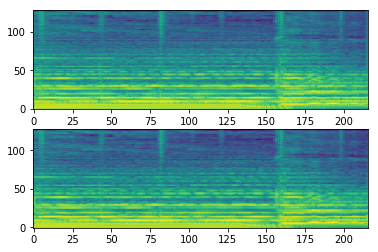

In [54]:
fig, axs = plt.subplots(2,1)
Y2_log = _log_amp(Y2)
axs[0].imshow(Y[0].T*1.5, aspect='auto', origin='low')
axs[1].imshow(Y2_log[0].T, aspect='auto', origin='low')

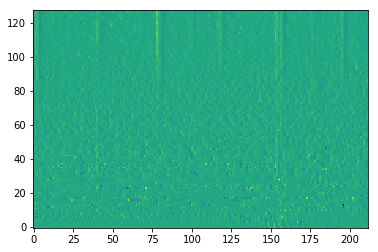

In [153]:
plt.imshow(np.abs(Y[0].T - Y3[0].T)[:, 2:-2], aspect='auto', origin='low')

In [158]:
np.isclose(np.exp(Y[0, 2:-2].T*1.99),np.exp(Y2_log[0, 2:-2].T)).sum() / float(np.prod(Y[0].size))

0.89279513888888884

In [157]:
np.isclose(10**Y[0,2:-2].T,10**Y3[0][2:-2].T).sum() / float(np.prod(Y[0].size))

0.8910951967592593

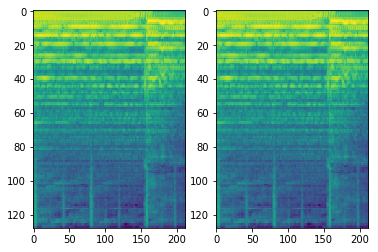

In [163]:
fig, axs = plt.subplots(1,2)
axs[0].imshow(Y[0,2:-2].T, aspect='auto')
axs[1].imshow(Y3[0][2:-2].T, aspect='auto')

In [124]:
import librosa
y, sr = librosa.load('/home/ubuntu/downloads/NAUL.mp3', sr=22050, mono=False)

In [135]:
st = int(20 * sr)
Y3 = [
    _log_amp(librosa.feature.melspectrogram(ch, sr=sr, n_fft=1024, hop_length=256, power=1)).T
    for ch in y[:, st:st+int(sr*2.5)]
]

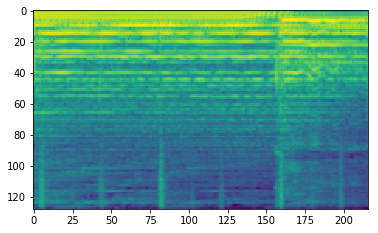

In [133]:
plt.imshow(Y3[0])

# Empirical test using librosa.feature.melspectrogram (pow=1)

In [281]:
from model.model import Model
import namedtupled
from sklearn.externals import joblib

state = joblib.load('/mnt/bulk2/exp_res/models/9/conv_2d_bpm_self_artist_tag_50_intersc_b2_run9_state.dat.gz')
state_nt = namedtupled.map(state)
model = Model(state_nt.config)

(None, 2, 216, 128)
(None, 2, 216, 128)
('conv1.pl', (None, 16, 54, 64))
('bpm.conv2.pl', (None, 32, 27, 32))
('bpm.conv3.pl', (None, 64, 13, 16))
('bpm.conv4.pl', (None, 64, 6, 8))
('bpm.conv5.pl', (None, 128, 3, 4))
('bpm.conv6.2.bn.nonlin', (None, 256, 3, 4))
('self.conv2.pl', (None, 32, 27, 32))
('self.conv3.pl', (None, 64, 13, 16))
('self.conv4.pl', (None, 64, 6, 8))
('self.conv5.pl', (None, 128, 3, 4))
('self.conv6.2.bn.nonlin', (None, 256, 3, 4))
('artist_tag.conv2.pl', (None, 32, 27, 32))
('artist_tag.conv3.pl', (None, 64, 13, 16))
('artist_tag.conv4.pl', (None, 64, 6, 8))
('artist_tag.conv5.pl', (None, 128, 3, 4))
('artist_tag.conv6.2.bn.nonlin', (None, 256, 3, 4))
(None, 50)
(None, 2)
(None, 50)
Loadong pre-trained weight...


In [282]:
model.config.target

[u'bpm', u'self', u'artist_tag']

In [283]:
f_gpumel = model.feature('bpm', Y[None, :, :, :])
f_librosamel = model.feature('bpm', np.array(Y3)[None, :, :, :])

('close numbers:', 154)


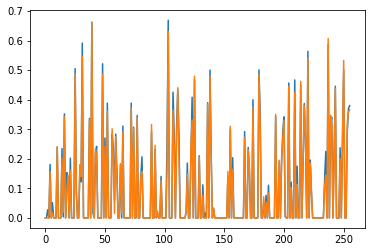

In [284]:
plt.plot(f_gpumel[0])
plt.plot(f_librosamel[0])
print('close numbers:', np.isclose(f_gpumel, f_librosamel).sum())

## Is feature varying a lot across music?

In [323]:
from sklearn.preprocessing import StandardScaler
sclr = StandardScaler()

music_length = len(y) / sr  # in sec
win_sz = int(2.5 * sr)
hop_sz = win_sz / 2
target = 'artist_tag'

X = []
Z = []
for n in range(0, y.shape[-1], hop_sz):
    input_ = np.array([
        _log_amp(librosa.feature.melspectrogram(ch, sr=sr, n_fft=1024, hop_length=256, power=1)).T
        for ch in y[:, n:n+win_sz]
    ])[None, :, :, :]
    
    if input_.shape[2] < 216:
        continue
        
    X.append(model.feature(target, input_).ravel())
#     Z.append(model.predict(target, input_).ravel())

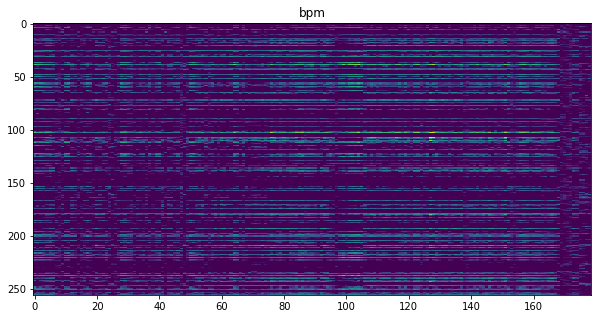

In [303]:
plt.figure(figsize=(10, 5))
plt.title('bpm')
plt.imshow(sclr.fit_transform(np.array(X)).T[:,10:-15], aspect='auto')

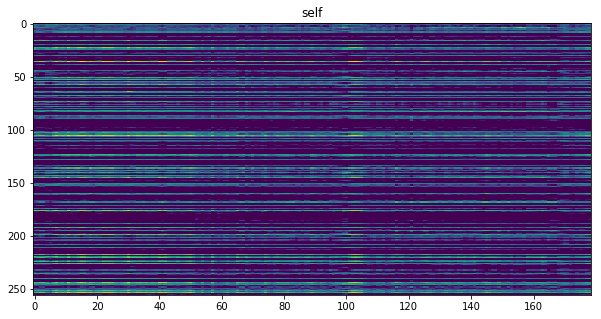

In [309]:
plt.figure(figsize=(10, 5))
plt.title('self')
plt.imshow(np.array(X).T[:,10:-15], aspect='auto')

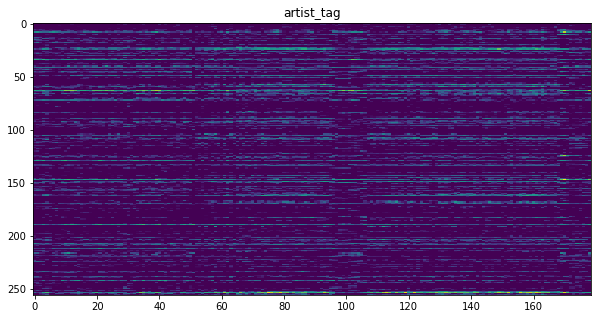

In [324]:
plt.figure(figsize=(10, 5))
plt.title('artist_tag')
plt.imshow(np.array(X).T[:,10:-15], aspect='auto')

In [325]:
from sklearn.decomposition import NMF, PCA
# mdl = NMF(n_components=21)
mdl = PCA(n_components=21, whiten=True)
U = mdl.fit_transform(sclr.fit_transform(X))
V = mdl.components_

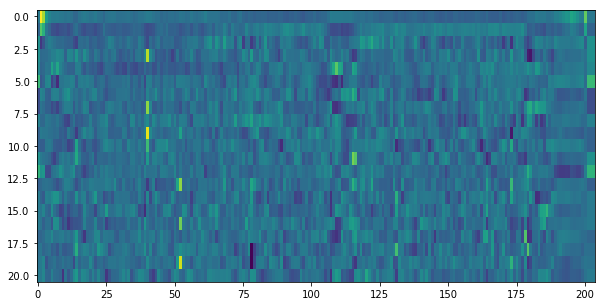

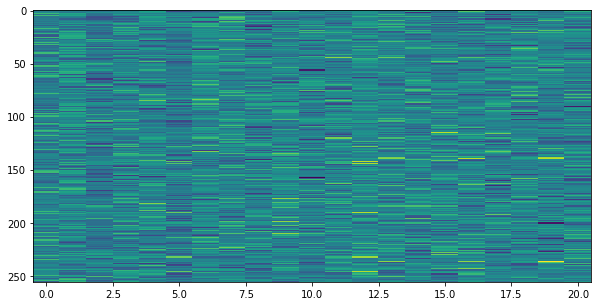

In [326]:
plt.figure(figsize=(10, 5))
plt.imshow(U.T, aspect='auto')
plt.figure(figsize=(10, 5))
plt.imshow(V.T, aspect='auto')


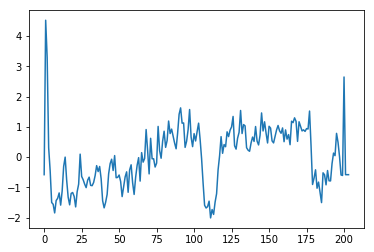

In [333]:
plt.plot(U[:,1])